In [31]:
# # Install scikit-learn for all the core metrics and modeling
# %pip install scikit-learn

# # Install imbalanced-learn for handling imbalanced datasets 
# %pip install imbalanced-learn

# import sys
# !{sys.executable} -m pip install -q scikit-learn imbalanced-learn joblib

# 1: Project Setup and Data Acquisition

In [32]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder , FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.neural_network import MLPClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr


try:
    df = pd.read_csv('bank-additional.csv', sep=';')
    print("Data loaded.")
except FileNotFoundError:
    print("Error: bank-additional.csv not found. Please ensure the file is in the correct path and try again.")
    df = pd.DataFrame() 

if not df.empty:
    
    # print("\nFirst 5 rows:")
    # print(df.head())

    # check missing values
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print(" No missing values")
    else:
        print(missing[missing > 0])

    # Check duplicates
    duplicates = df.duplicated().sum()
    print(f"Found {duplicates} duplicate rows")
    
    print("\nStatistical Summary:")
    print(df.describe(include='all'))
    
    # Target variable distribution
    print("TARGET VARIABLE DISTRIBUTION")
    # Target encoding (yes=1, no=0)
    df['y'] = df['y'].astype(str).str.strip().str.lower()
    df['y'] = df['y'].map({'yes': 1, 'no': 0})

    # Kaç tane NaN kaldı kontrol
    print("y NaN count:", df['y'].isna().sum())
    print("y value counts:\n", df['y'].value_counts(dropna=False))
    #print(df['y'].value_counts())
    #print(f"\nClass Imbalance Ratio: {df['y'].value_counts()['no']/df['y'].value_counts()['yes']:.2f}:1")


Data loaded.
 No missing values
Found 0 duplicate rows

Statistical Summary:
                age     job  marital          education default housing  loan  \
count   4119.000000    4119     4119               4119    4119    4119  4119   
unique          NaN      12        4                  8       3       3     3   
top             NaN  admin.  married  university.degree      no     yes    no   
freq            NaN    1012     2509               1264    3315    2175  3349   
mean      40.113620     NaN      NaN                NaN     NaN     NaN   NaN   
std       10.313362     NaN      NaN                NaN     NaN     NaN   NaN   
min       18.000000     NaN      NaN                NaN     NaN     NaN   NaN   
25%       32.000000     NaN      NaN                NaN     NaN     NaN   NaN   
50%       38.000000     NaN      NaN                NaN     NaN     NaN   NaN   
75%       47.000000     NaN      NaN                NaN     NaN     NaN   NaN   
max       88.000000     NaN     

# 2: Data Cleaning and Preparation 

In [33]:

if not df.empty:
    print("Target is already encoded (0/1).")
    print(df['y'].value_counts())

    # 2. Handle 'unknown' values with domain-informed strategy
    print("HANDLING 'UNKNOWN' VALUES IN CATEGORICAL FEATURES")
    
    categorical_cols = df.select_dtypes(include='object').columns
    
    # First, identify all 'unknown' values
    print("\n 'Unknown' Value Analysis:")
    for col in categorical_cols:
        unknown_count = (df[col] == 'unknown').sum()
        if unknown_count > 0:
            pct = unknown_count/len(df)*100
            print(f"  • {col}: {unknown_count} ({pct:.1f}%)")
    

    # Strategy: Context-based handling
    # - Very small % (<1%): Impute with mode (noise reduction)
    # - Larger %: Keep as separate category (likely informative)
    
    print("\n Handling Strategy:")
    
    # Impute 'marital' (only 0.3% - too small to be informative)
    if 'marital' in df.columns:
        m = df['marital'].mode()
        marital_mode = m.iloc[0] if len(m) > 0 else 'married'
        unknown_count = (df['marital'] == 'unknown').sum()
        if unknown_count > 0:
            df['marital'] = df['marital'].replace('unknown', marital_mode)
            print(f"   'marital': Imputed {unknown_count} 'unknown' values with mode '{marital_mode}'")
            print(f"    Reason: Only 0.3% unknown - too small to be meaningful")
    
    # Keep 'unknown' as a category for all others
    keep_unknown = ['job', 'education', 'default', 'housing', 'loan']
    for col in keep_unknown:
        if col in df.columns:
            unknown_count = (df[col] == 'unknown').sum()
            if unknown_count > 0:
                pct = unknown_count/len(df)*100
                print(f"  '{col}': Keeping 'unknown' as separate category ({pct:.1f}%)")
                if col == 'default':
                    print(f"    Reason: High % (19.5%) - 'unknown' credit status is informative")
                elif pct > 1:
                    print(f"    Reason: {pct:.1f}% is substantial - may contain signal")
    

    #  Feature Engineering
    print("FEATURE ENGINEERING")
   
    # Feature 1: Previous contact indicator
    df['was_previously_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
    print(" Created 'was_previously_contacted': Binary indicator (999 = never contacted before)")
    
    # Feature 2: Campaign efficiency
    df['campaign_successful'] = df['campaign'].apply(lambda x: 1 if x < 5 else 0)
    print(" Created 'campaign_successful': Efficient campaign (< 5 contacts)")
    
    # Feature 3: Previous outcome success
    df['poutcome_success'] = df['poutcome'].map({'success': 1, 'failure': 0, 'nonexistent': 0})
    print(" Created 'poutcome_success': Binary success indicator")
    

    # Feature 4: Age groups (additional suggestion)
    df['age_group'] = pd.cut(df['age'], 
                             bins=[0, 30, 40, 50, 60, 100], 
                             labels=['18-30', '31-40', '41-50', '51-60', '60+'])
    

    print(" Created 'age_group': Categorical age bins for better interpretability")
    print(f"\n Total engineered features: 4")
    

    # Final dataset check
    print("FINAL DATASET OVERVIEW")
    print(f"Final dataset shape: {df.shape}")
    print(f"\nFinal Target Distribution:")
    print(df['y'].value_counts())
    print(f"\nClass ratio (No:Yes) = {df['y'].value_counts()[0]/df['y'].value_counts()[1]:.2f}:1")
    print(" Severe class imbalance detected - will use class_weight='balanced'")

Target is already encoded (0/1).
y
0    3668
1     451
Name: count, dtype: int64
HANDLING 'UNKNOWN' VALUES IN CATEGORICAL FEATURES

 'Unknown' Value Analysis:
  • job: 39 (0.9%)
  • marital: 11 (0.3%)
  • education: 167 (4.1%)
  • default: 803 (19.5%)
  • housing: 105 (2.5%)
  • loan: 105 (2.5%)

 Handling Strategy:
   'marital': Imputed 11 'unknown' values with mode 'married'
    Reason: Only 0.3% unknown - too small to be meaningful
  'job': Keeping 'unknown' as separate category (0.9%)
  'education': Keeping 'unknown' as separate category (4.1%)
    Reason: 4.1% is substantial - may contain signal
  'default': Keeping 'unknown' as separate category (19.5%)
    Reason: High % (19.5%) - 'unknown' credit status is informative
  'housing': Keeping 'unknown' as separate category (2.5%)
    Reason: 2.5% is substantial - may contain signal
  'loan': Keeping 'unknown' as separate category (2.5%)
    Reason: 2.5% is substantial - may contain signal
FEATURE ENGINEERING
 Created 'was_previousl

#  Feature Engineering Functions (Used Inside the Pipeline)

In [36]:
from sklearn.preprocessing import FunctionTransformer

def add_engineered_features(X):
    """
    This function performs all feature engineering steps inside the pipeline.
    It ensures that the same transformations are applied consistently
    during both training and inference (e.g., Streamlit predictions).
    """
    X = X.copy()

    # 1) Age grouping
    # Convert the numerical age feature into categorical age groups
    # to improve interpretability and capture non-linear age effects.
    X["age_group"] = pd.cut(
        X["age"],
        bins=[0, 30, 40, 50, 60, 100],
        labels=["18-30", "31-40", "41-50", "51-60", "60+"]
    )

    # 2) Previous contact indicator
    # Create a binary feature indicating whether the client
    # has been contacted in previous campaigns.
    X["was_previously_contacted"] = (X["previous"] > 0).astype(int)

    # 3) Campaign efficiency indicator
    # Mark campaigns with fewer than 5 contacts as "efficient",
    # based on domain knowledge and exploratory analysis.
    X["campaign_successful"] = (X["campaign"] < 5).astype(int)

    # 4) Previous campaign outcome success
    # Encode whether the outcome of the previous campaign
    # was successful as a binary feature.
    X["poutcome_success"] = (X["poutcome"] == "success").astype(int)

    return X

# 4: Data Preprocessing and Creating Pipeline


In [37]:
if not df.empty:

    #pipeline yaptığımız için artık ihtiyaç yok 
    # --- Feature engineering (Streamlit-compatible: no pdays, no duration) ---
    # df["was_previously_contacted"] = (df["previous"] > 0).astype(int)
    # df["campaign_successful"] = (df["campaign"] < 5).astype(int)
    # df["poutcome_success"] = (df["poutcome"] == "success").astype(int)

    # Drop columns that are not used in the Streamlit app (ignore if missing)
    df = df.drop(columns=["duration", "pdays"], errors="ignore")

    # Separate features and target
    X = df.drop("y", axis=1)
    y = df["y"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Feature groups
    numerical_features = [
        "age", "campaign", "previous",
        "emp.var.rate", "cons.price.idx",
        "cons.conf.idx", "euribor3m", "nr.employed"
    ]

    categorical_features = [
        "job", "marital", "education", "default",
        "housing", "loan", "contact",
        "month", "day_of_week", "poutcome",
        "age_group"
    ]

    engineered_features = [
        "was_previously_contacted",
        "campaign_successful",
        "poutcome_success"
    ]

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_features),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
            ("bin", "passthrough", engineered_features)
        ],
        remainder="drop"
    )

    print("Preprocessor created successfully.")

print("pdays in df:", "pdays" in df.columns)
print("X columns count:", X.shape[1])



Preprocessor created successfully.
pdays in df: False
X columns count: 22


# 5: Feature Selection and Model Selection

In [38]:

if not df.empty:

    # Re-define fixed preprocessor for robustness within this cell
    features_to_scale = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
    categorical_features = X_train.select_dtypes(include='object').columns.tolist()
    engineered_passthrough = ['was_previously_contacted', 'campaign_successful', 'poutcome_success']
    
    preprocessor_fixed = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), features_to_scale),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
            ('bin', 'passthrough', engineered_passthrough)
        ],
        remainder='drop' 
    )
 
    # --- Define Pipelines for Model Comparison
    logreg_pipe = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(add_engineered_features, validate=False)),
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        solver='liblinear',
        class_weight='balanced'
    ))
])

rf_pipe = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(add_engineered_features, validate=False)),
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

mlp_pipe = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(add_engineered_features, validate=False)),
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(
        random_state=42,
        max_iter=300
    ))
])



models = {'Logistic Regression': logreg_pipe, 'Random Forest': rf_pipe, 'MLP Classifier': mlp_pipe}

results = {}
print("\nTraining and Evaluating Models (using binary labels and class_weight='balanced')...")
    
from sklearn.metrics import f1_score, recall_score, roc_auc_score

results = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {'F1-Score': f1, 'Recall': recall, 'ROC AUC': roc_auc}
    print(f"--- {name} ---")
    print(f"F1-Score: {f1:.4f}, Recall: {recall:.4f}, ROC AUC: {roc_auc:.4f}")

best_model_name = max(results, key=lambda k: results[k]["F1-Score"])
print("\nSelected Model for Tuning (based on F1-Scoreaaa):", best_model_name)



Training and Evaluating Models (using binary labels and class_weight='balanced')...
--- Logistic Regression ---
F1-Score: 0.4215, Recall: 0.5667, ROC AUC: 0.7592
--- Random Forest ---
F1-Score: 0.2202, Recall: 0.1333, ROC AUC: 0.7490
--- MLP Classifier ---
F1-Score: 0.2400, Recall: 0.2000, ROC AUC: 0.6262

Selected Model for Tuning (based on F1-Scoreaaa): Logistic Regression


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


# 6: Hyperparameter Tuning and Feature Selection

In [39]:
if not df.empty:
   
    best_model_name = 'Logistic Regression' 
    
    # 1. Define the Feature Selection component 
    # Use SelectKBest with f_classif to select features BEFORE LR training.
    feature_selector = SelectKBest(score_func=f_classif) 

    # 2. Define the FINAL PIPELINE: Preprocessor -> Feature Selector -> Classifier (LR)
    final_pipeline = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(add_engineered_features, validate=False)),
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=3000, class_weight='balanced'))
])

    
    # 3. Define the parameter grid for Logistic Regression and Feature Selection
    param_grid = {
        # Tuning parameters for Feature Selection
        'feature_selection__k': [20, 30, 'all'], # Tune the number of features to keep
        
        # Tuning parameters for Logistic Regression
        'classifier__C': [0.1, 1, 10], # Regularization strength
        'classifier__penalty': ['l1', 'l2'],
        #'classifier__class_weight': ['balanced', None] 
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        final_pipeline, 
        param_grid, 
        cv=5, 
        scoring='roc_auc', # Optimize for ROC AUC
        n_jobs=-1, 
        verbose=1
    )

    print(f"\nStarting GridSearchCV for {best_model_name} with Feature Selection...")
 
    grid_search.fit(X_train, y_train)

    final_model = grid_search.best_estimator_
    print("\nBest Parameters found by GridSearchCV:")
    print(grid_search.best_params_)





Starting GridSearchCV for Logistic Regression with Feature Selection...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters found by GridSearchCV:
{'classifier__C': 10, 'classifier__penalty': 'l2', 'feature_selection__k': 20}


# 7: Evaluation of the Final Model


*** Final Model Performance on Test Set ***
Accuracy: 0.8471
Recall (Subscription 'yes'): 0.6000
Precision (Subscription 'yes'): 0.3750
F1-Score: 0.4615
ROC AUC: 0.8017

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       734
           1       0.38      0.60      0.46        90

    accuracy                           0.85       824
   macro avg       0.66      0.74      0.69       824
weighted avg       0.88      0.85      0.86       824



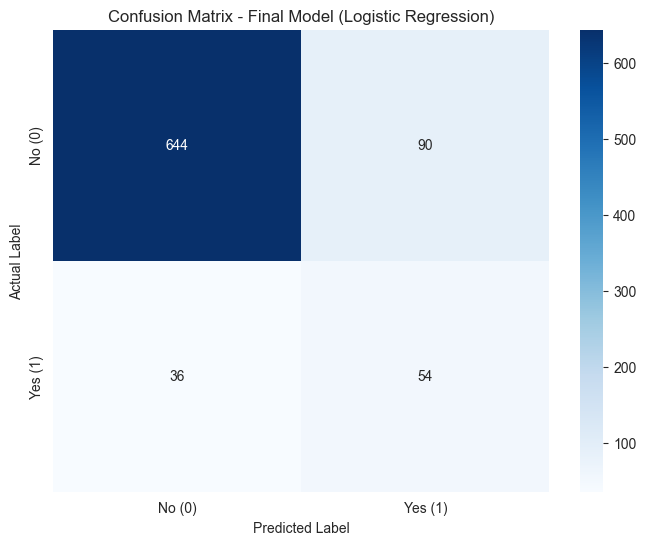


Features Selected by SelectKBest:
Optimal number of features (k) kept: 20
Selected Feature Names (first 30):
 - num__campaign
 - num__previous
 - num__emp.var.rate
 - num__cons.price.idx
 - num__euribor3m
 - num__nr.employed
 - cat__default_no
 - cat__contact_cellular
 - cat__contact_telephone
 - cat__month_dec
 - cat__month_mar
 - cat__month_may
 - cat__month_oct
 - cat__month_sep
 - cat__poutcome_nonexistent
 - cat__poutcome_success
 - cat__age_group_60+
 - bin__was_previously_contacted
 - bin__campaign_successful
 - bin__poutcome_success


In [40]:


if not df.empty:
    y_test_pred = final_model.predict(X_test)
    y_test_proba = final_model.predict_proba(X_test)[:, 1]

    final_accuracy = accuracy_score(y_test, y_test_pred)
    final_recall = recall_score(y_test, y_test_pred)
    final_precision = precision_score(y_test, y_test_pred)
    final_f1 = f1_score(y_test, y_test_pred)
    final_roc_auc = roc_auc_score(y_test, y_test_proba)

    print("\n*** Final Model Performance on Test Set ***")
    print(f"Accuracy: {final_accuracy:.4f}")
    print(f"Recall (Subscription 'yes'): {final_recall:.4f}")
    print(f"Precision (Subscription 'yes'): {final_precision:.4f}")
    print(f"F1-Score: {final_f1:.4f}")
    print(f"ROC AUC: {final_roc_auc:.4f}")


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))


    # Confusion Matrix Plot 
    cm = confusion_matrix(y_test, y_test_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No (0)', 'Yes (1)'], 
                yticklabels=['No (0)', 'Yes (1)'])
   
    plt.title(f'Confusion Matrix - Final Model ({best_model_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Selection Output 

# Feature Selection Output
try:
    selector = final_model.named_steps['feature_selection']
    preprocessor_step = final_model.named_steps['preprocessor']

    # Get all feature names generated by the preprocessor
    all_feature_names = preprocessor_step.get_feature_names_out()

    # Get selected feature mask from SelectKBest
    selected_mask = selector.get_support()
    selected_features = all_feature_names[selected_mask]

    print("\nFeatures Selected by SelectKBest:")
    print(f"Optimal number of features (k) kept: {len(selected_features)}")
    print("Selected Feature Names (first 30):")

    for feature in selected_features[:30]:
        print(f" - {feature}")

except Exception as e:
    print(f"\nCould not display feature selection details. Error: {e}")



In [41]:
# Save the final model
import joblib
joblib.dump(final_model, 'final_bank_marketing_model.joblib')
print("\n Model saved successfully as 'final_bank_marketing_model.joblib'")


 Model saved successfully as 'final_bank_marketing_model.joblib'
